In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [61]:
# Load the data
aryl_scope = pd.read_csv('datasets/Good_Datasets/aryl-scope-ligand.csv')
deoxy = pd.read_csv('datasets/Good_Datasets/deoxyf.csv')
etoh = pd.read_csv('datasets/Good_Datasets/nib-etoh.csv')
meoh = pd.read_csv('datasets/Good_Datasets/nib-meoh.csv')

In [62]:
def create_mat(data, r1_title, r2_title, cond_title, target_title):
    # Create a matrix of the data
    unique_r1 = data[r1_title].unique()
    unique_r2 = data[r2_title].unique()
    unique_cond = data[cond_title].unique()
    data_mat = np.zeros((len(unique_r1), len(unique_r2), len(unique_cond)))
    for i, r1 in enumerate(unique_r1):
        for j, r2 in enumerate(unique_r2):
            for k, cond in enumerate(unique_cond):
                data_mat[i, j, k] = data[(data[r1_title] == r1) & (data[r2_title] == r2) & (data[cond_title] == cond)][target_title].values[0]
    # for i in range(len(unique_r1)):
    #     for j in range(len(unique_r2)):
    #         data_mat[i, j] = data[(data[r1_title] == r1[i]) & (data[r2_title] == r2[j])]['yield'].values[0]
    return data_mat

In [4]:
def plot_surface(data, xlabel='Reactant A', ylabel='Reactant B', zlabel = '% Yield', title='Surface Plot'):    
    # max_yield_surface = np.zeros((num_block_B, num_block_A))
    # surf = surf.T
    # print(len(surf))
    # print(num_block_A)
    # for i in range(num_block_B):
    #     for j in range(num_block_A):
    #         max_yield_surface[i][j] += np.amax(surf[i][j])
    # max_yield_surface = max_yield_surface.T
    max_yield_surface = np.amax(data, axis=2)
    plt.imshow(max_yield_surface)
    plt.colorbar(label=zlabel)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    # plt.zlabel('Conditions')
    plt.title(title, fontsize=20)
    # plt.savefig(f'correlated_toy_{num_conditions}x{num_block_A}x{num_block_B}_1.png')
    plt.show()
    return

In [63]:
aryl_scope_mat = create_mat(aryl_scope, 'electrophile_id', 'nucleophile_id', 'ligand_name', 'yield')

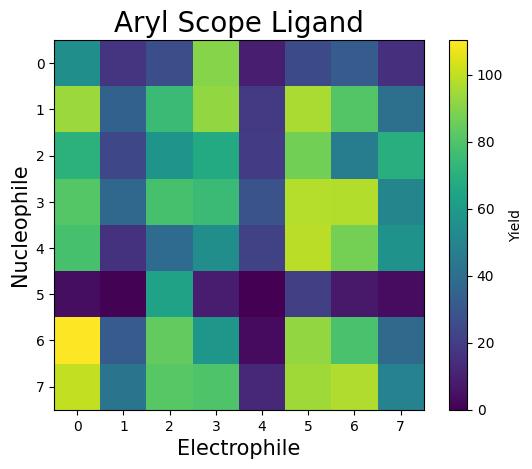

In [170]:
plot_surface(aryl_scope_mat, 'Electrophile', 'Nucleophile', 'Yield', 'Aryl Scope Ligand')

In [7]:
deoxy_mat = create_mat(deoxy, 'substrate_name', 'fluoride_name', 'base_name', 'yield')

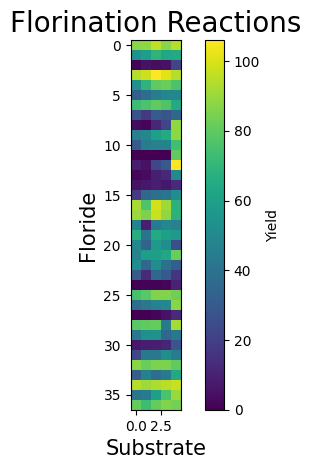

In [171]:
plot_surface(deoxy_mat, 'Substrate', 'Floride', 'Yield', 'Florination Reactions')

In [175]:
etoh.head()

,Unnamed: 0,electrophile_id,ligand_name,yield
0,0,s1,A-paPhos,87.13
1,1,s1,CX-FBu,6.37
2,2,s1,CX-PCy,71.75
3,3,s1,Cy-BippyPhos,64.52
4,4,s1,Cy-JohnPhos,80.44


In [176]:
etoh['solvent'] = 'etoh'
meoh['solvent'] = 'meoh'
borylation = pd.concat([etoh, meoh], ignore_index=True)

In [177]:
borylation

,Unnamed: 0,electrophile_id,ligand_name,yield,solvent
0,0,s1,A-paPhos,87.13,etoh
1,1,s1,CX-FBu,6.37,etoh
2,2,s1,CX-PCy,71.75,etoh
3,3,s1,Cy-BippyPhos,64.52,etoh
4,4,s1,Cy-JohnPhos,80.44,etoh
...,...,...,...,...,...
1513,754,s33,P(p-F-Ph)3,86.07,meoh
1514,755,s33,PCy3 HBF4,21.31,meoh
1515,756,s33,Cy-vBRIDP,62.96,meoh
1516,757,s33,P(o-Anis)3,48.97,meoh


In [178]:
borylation_mat = create_mat(borylation, 'electrophile_id', 'ligand_name', 'solvent', 'yield')

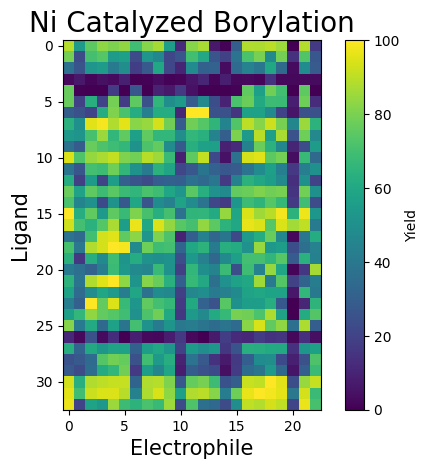

In [179]:
plot_surface(borylation_mat, 'Electrophile', 'Ligand', 'Yield', 'Ni Catalyzed Borylation')

In [64]:
def count_coverage_for_set(classifier_surface, set):
    covered = classifier_surface[set[0]]
    for i in range(1,len(set)):
        covered = np.logical_or(covered, classifier_surface[set[i]])
    return np.sum(covered, axis=(0,1))

In [65]:
def best_x_condition_sets(surface, x):
    possible_combos = list(itertools.combinations(range(len(surface)), x))
    coverages = [count_coverage_for_set(surface, set) for set in possible_combos]
    return possible_combos, coverages

In [93]:
def show_conditions(surface:np.array, conditions, xlabel='Reactant A', ylabel='Reactant B', threshold=0):
    yields = np.zeros(surface.shape[1:])
    for condition in conditions:
        yields = np.maximum(yields, surface[condition])
        # surface[condition]
    for i in range(len(yields)):
        for j in range(len(yields[0])):
            if yields[i,j] < threshold:
                yields[i,j] = 0
    # plt.size = (6,6)
    plt.imshow(yields.T, vmin=0, vmax=100)
    plt.colorbar(label='% Yield')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    # plt.zlabel('Conditions')
    condition_str = ', '.join([str(c) for c in conditions])
    if len(conditions) == 1:
        condition_str = f"Condition {conditions[0]} Yield"
    else:
        condition_str = f"Conditions {condition_str} Max Yield"
    plt.title(f'{condition_str}', fontsize=20)
    plt.show()

In [66]:
def create_classifier_surface(surface, threshold):
    return surface > threshold

In [67]:
best_cond_1 = best_x_condition_sets(create_classifier_surface(aryl_scope_mat.T, 40), 1)
best_cond_2 = best_x_condition_sets(create_classifier_surface(aryl_scope_mat.T, 40),2)
best_cond_3 = best_x_condition_sets(create_classifier_surface(aryl_scope_mat.T, 50),3)

In [72]:
best_cond_2[1][best_cond_2[0].index((0,20))]

32

In [16]:
best_cond_3[1][np.argmax(best_cond_3[1])]

33

In [136]:
best_cond_1[0][np.argmax(best_cond_1[1])]

(18,)

In [98]:
max(best_cond_1[1])

35

In [99]:
max(best_cond_2[1])

38

In [100]:
best_cond_1[0][np.argsort(best_cond_1[1])[-1]]

(18,)

In [143]:
best_cond_2[1][np.argsort(best_cond_2[1])[-1]]

43

In [137]:
best_cond_2[0][np.argmax(best_cond_2[1])]

(16, 20)

In [ ]:
aryl_scope_mat

In [4]:
show_conditions(aryl_scope_mat.T, best_cond_1[0][np.argmax(best_cond_1[1])], threshold=40, xlabel='Electrophile', ylabel='Nucleophile')

NameError: name 'show_conditions' is not defined

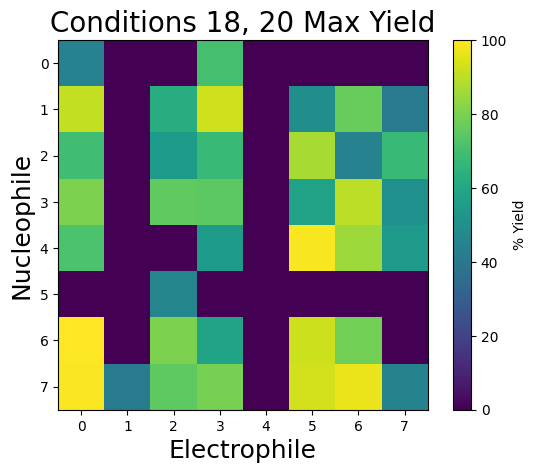

In [160]:
show_conditions(aryl_scope_mat.T, best_cond_2[0][np.argmax(best_cond_2[1])], threshold=40, xlabel='Electrophile', ylabel='Nucleophile')

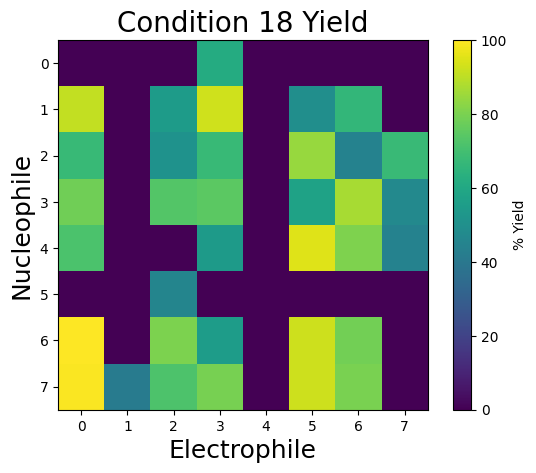

In [161]:
show_conditions(aryl_scope_mat.T, (best_cond_2[0][np.argmax(best_cond_2[1])][0],), threshold=40, xlabel='Electrophile', ylabel='Nucleophile')

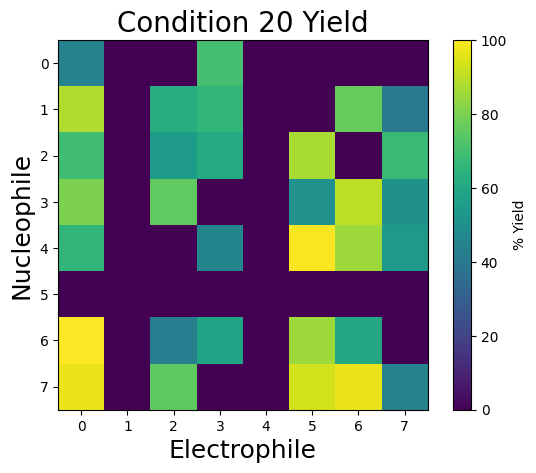

In [162]:
show_conditions(aryl_scope_mat.T, (best_cond_2[0][np.argmax(best_cond_2[1])][1],), threshold=40, xlabel='Electrophile', ylabel='Nucleophile')

In [22]:
with open('metrics_2024-05-15_11:08:37.txt', 'r') as f:
    lines = f.read().splitlines()
    accuracy = lines[0]
    accuracy = accuracy.split('[')[-1][:-1]
    accuracy = [float(x) for x in accuracy.split(', ')]
    precision = lines[1]
    precision = precision.split('[')[-1][:-1]
    precision = [float(x) for x in precision.split(', ')]
    recall = lines[2]
    recall = recall.split('[')[-1][:-1]
    recall = [float(x) for x in recall.split(', ')]

Text(0.5, 0, 'Batch')

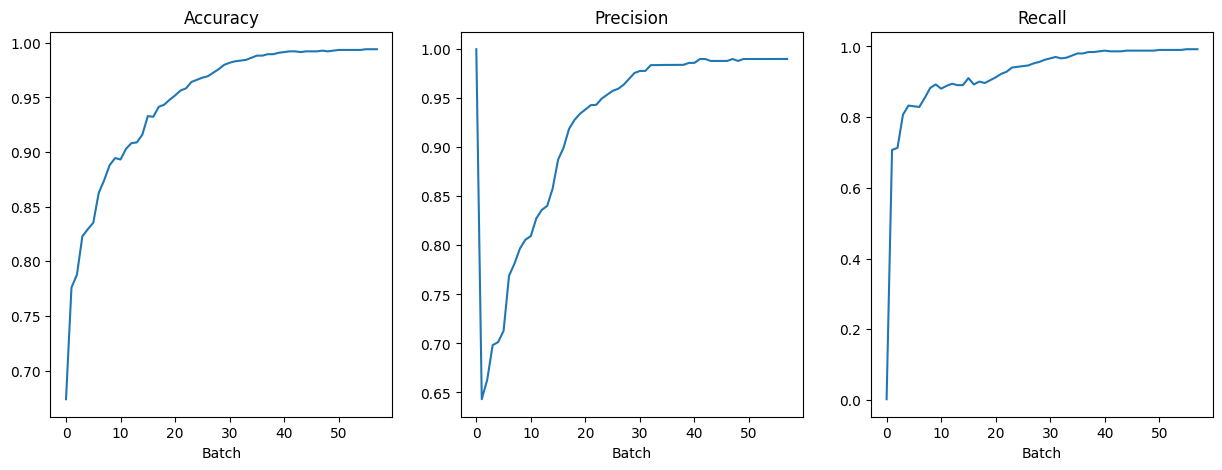

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(accuracy)
ax1.set_title('Accuracy')
ax1.set_xlabel('Batch')
ax2.plot(precision)
ax2.set_title('Precision')
ax2.set_xlabel('Batch')
ax3.plot(recall)
ax3.set_title('Recall')
ax3.set_xlabel('Batch')

In [28]:
BH_df = pd.read_hdf('datasets/share_science_models/final_model_all_y_arr.hdf5',key='df')
print(BH_df)

              114hpset0  110hpset0  115hpset2  116hpset2  115hpset0  \
1_1_1_1_a      0.339354   0.072328   0.642207   0.446863   3.856923   
1_1_1_1_b      0.044080   0.862622   5.943873   3.773814   8.704228   
1_1_1_1_c      0.573446   0.566944   0.744075   0.347473   1.652827   
1_1_1_2_a      1.194119   0.715357   0.234307   0.382247   4.497704   
1_1_1_2_b      2.037962   0.062995   5.621418   5.381562   8.471496   
...                 ...        ...        ...        ...        ...   
50_50_21_2_b  57.396370  39.811962  41.976391  33.123707  61.955162   
50_50_21_2_c   0.573446   0.238012   1.057673   2.964778  -0.995746   
50_50_21_3_a  10.892945  -0.136674  15.546334   0.389491  19.146662   
50_50_21_3_b  70.614944  46.924679  47.002640  48.858818  70.142685   
50_50_21_3_c   0.777323   0.439066   1.463304   2.758016   0.559224   

               10hpset0  100hpset1  104hpset2  109hpset2  102hpset2  ...  \
1_1_1_1_a      0.453000  -0.233525   0.226131  -0.598521  -0.125585  ..

In [29]:
mean_ = BH_df.mean(axis=1)
# std_ = BH_df.std(axis=1)

In [30]:
idxs = BH_df.index.str.split('_').to_list()

In [31]:
flipped_idxs = list(zip(*idxs))

In [32]:
# convert BH predictions into df (then hdf5)
# Amine, Bromide, Catalyst, Solvent, Base, Yield
BH_df['Yield'] = mean_
BH_df['Amine'] = flipped_idxs[0] 
BH_df['Bromide'] = flipped_idxs[1] 
BH_df['Catalyst'] = flipped_idxs[2] 
BH_df['Solvent'] = flipped_idxs[3] 
BH_df['Base'] = flipped_idxs[4]


In [34]:
BH_df_reduced = BH_df[['Amine', 'Bromide', 'Catalyst', 'Solvent', 'Base', 'Yield']]

In [36]:
BH_df_reduced.to_hdf('datasets/Good_Datasets/buchwald-hartwig.hdf5', key='df')

In [54]:
BH_df_reduced["Yield"]

0          0.444733
1          2.994999
2          0.403455
3          0.902547
4          2.549122
            ...    
449995    45.048321
449996     0.379357
449997     6.620378
449998    57.510551
449999     0.491170
Name: Yield, Length: 450000, dtype: float32

In [37]:
BH_df_reduced.index = range(len(BH_df_reduced))

In [47]:
max_yield_surface = np.zeros((50, 50))
for a in range(50):
    for b in range(50):
        start = ((a)*(180*50)+(b)*(180))
        # print(f"{BH_df_reduced[start:start+1]['Bromide']} {BH_df_reduced[start+ 179: start+180]['Bromide']}")
        max_yield_surface[a][b] = np.amax(BH_df_reduced[(start):(start)+180]['Yield'])

In [51]:
max_yield_surface[20][32]

62.43284606933594

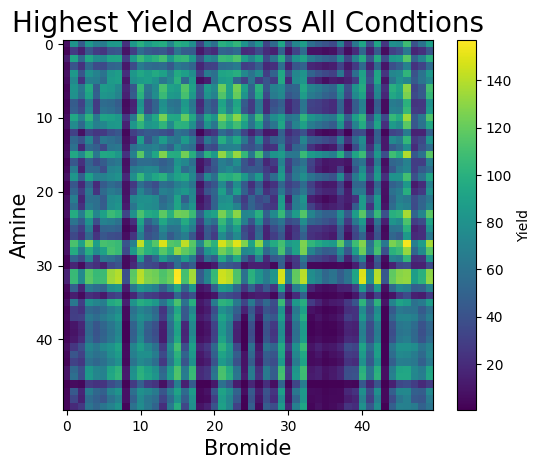

In [57]:

plt.imshow(max_yield_surface)
plt.colorbar(label="Yield")
plt.xlabel("Bromide", fontsize=15)
plt.ylabel("Amine", fontsize=15)
# plt.zlabel('Conditions')
plt.title("Highest Yield Across All Condtions", fontsize=20)
# plt.savefig(f'correlated_toy_{num_conditions}x{num_block_A}x{num_block_B}_1.png')
plt.show()

In [ ]:
def bh_count_coverage_for_set(classifier_surface, set):
    covered = classifier_surface[set[0]]
    for i in range(1,len(set)):
        covered = np.logical_or(covered, classifier_surface[set[i]])
    return np.sum(covered, axis=(0,1))

In [ ]:
def bh_best_x_condition_sets(surface, x):
    possible_combos = list(itertools.combinations(range(len(surface)), x))
    coverages = [count_coverage_for_set(surface, set) for set in possible_combos]
    return possible_combos, coverages

In [75]:
# create bh_mat
bh_mat = np.zeros((50,50,180))
for a in range(50):
    for b in range(50):
        for c in range(180):
            start = (a*50*180)+(b*180)+c
            bh_mat[a][b][c] = float(BH_df_reduced['Yield'].iloc[start])

In [76]:
bh_best_1 = best_x_condition_sets(create_classifier_surface(bh_mat.T, 50), 1)

In [78]:
bh_best_1[1][np.argmax(bh_best_1[1])]

735

In [79]:
bh_best_2 = best_x_condition_sets(create_classifier_surface(bh_mat.T, 50), 2)
bh_best_3 = best_x_condition_sets(create_classifier_surface(bh_mat.T, 50), 3)

In [81]:
print(bh_best_2[1][np.argmax(bh_best_2[1])])
print(bh_best_3[1][np.argmax(bh_best_3[1])])

1205
1278


In [92]:
print([f"{value}: {bh_best_1[1][index]}" for index, value in enumerate(bh_best_1[0]) if index in np.argsort(bh_best_1[1])[-20:]])
sorted_2 = np.argsort(bh_best_2[1])[-20:]
print([f"{value}: {bh_best_2[1][index]}" for index, value in enumerate(bh_best_2[0]) if index in sorted_2])
sorted_3 = np.argsort(bh_best_3[1])[-20:]
print([f"{value}: {bh_best_3[1][index]}" for index, value in enumerate(bh_best_3[0]) if index in sorted_3])

['(13,): 517', '(54,): 539', '(57,): 697', '(60,): 553', '(63,): 510', '(66,): 672', '(67,): 580', '(69,): 518', '(75,): 589', '(120,): 548', '(121,): 527', '(136,): 709', '(139,): 729', '(142,): 702', '(163,): 690', '(166,): 689', '(169,): 697', '(172,): 735', '(175,): 627', '(178,): 721']
['(57, 136): 1158', '(57, 139): 1159', '(57, 142): 1160', '(57, 163): 1193', '(57, 166): 1157', '(57, 169): 1197', '(57, 172): 1205', '(57, 178): 1197', '(66, 136): 1135', '(66, 139): 1136', '(66, 142): 1137', '(66, 163): 1168', '(66, 166): 1134', '(66, 169): 1172', '(66, 172): 1180', '(66, 178): 1172', '(75, 163): 1114', '(75, 169): 1118', '(75, 172): 1128', '(75, 178): 1119']
['(57, 58, 163): 1249', '(57, 58, 169): 1252', '(57, 58, 172): 1252', '(57, 58, 178): 1245', '(57, 67, 163): 1275', '(57, 67, 169): 1278', '(57, 67, 172): 1275', '(57, 67, 178): 1268', '(57, 136, 169): 1245', '(57, 139, 163): 1263', '(57, 139, 169): 1266', '(57, 139, 172): 1266', '(57, 139, 178): 1264', '(57, 142, 169): 1247'

In [ ]:
print()

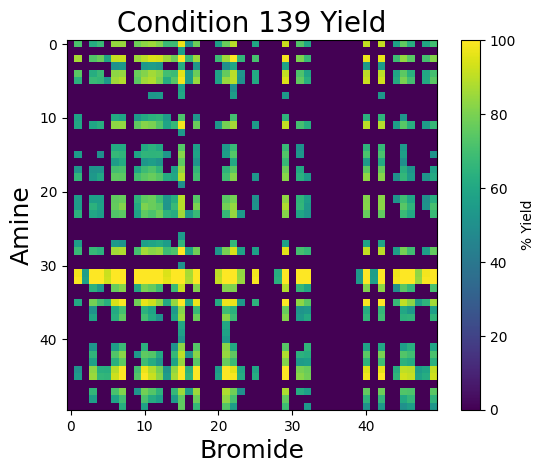

In [100]:
show_conditions(bh_mat.T, (139,), threshold=50, xlabel='Bromide', ylabel='Amine')

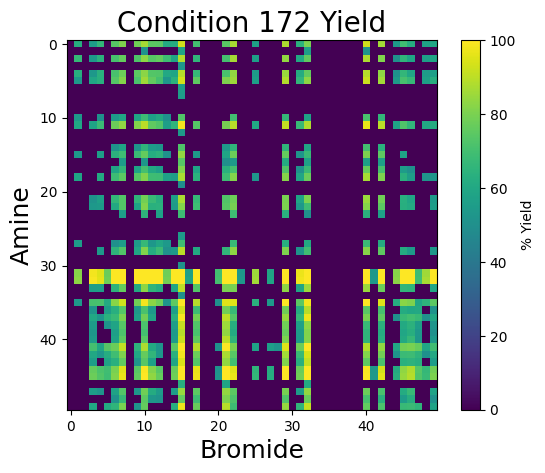

In [98]:
show_conditions(bh_mat.T, bh_best_1[0][np.argmax(bh_best_1[1])], threshold=50, xlabel='Bromide', ylabel='Amine')

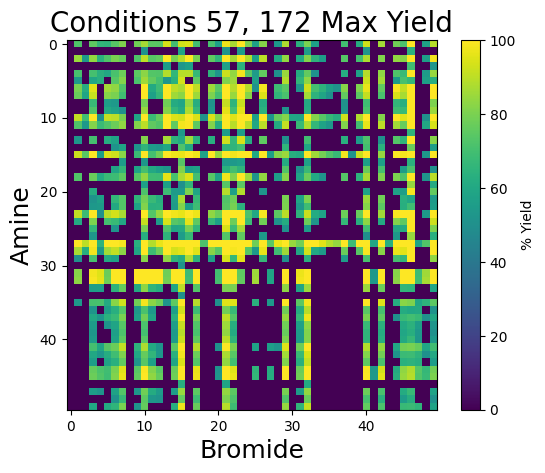

In [97]:
show_conditions(bh_mat.T, bh_best_2[0][np.argmax(bh_best_2[1])], threshold=50, xlabel='Bromide', ylabel='Amine')

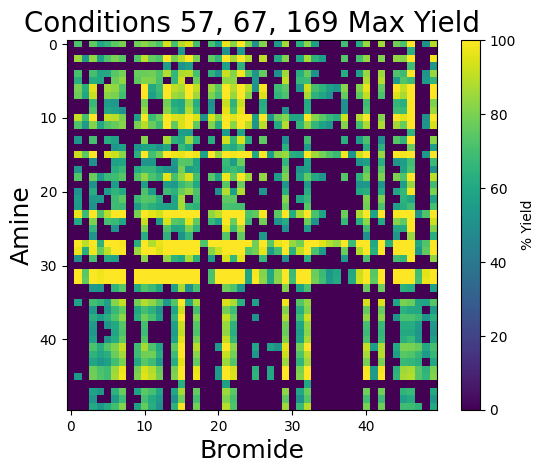

In [99]:
show_conditions(bh_mat.T, bh_best_3[0][np.argmax(bh_best_3[1])], threshold=50, xlabel='Bromide', ylabel='Amine')

In [103]:
def cond_num_to_parts(cond_num):
    c = int(cond_num / 9)
    if c > 14:
        c += 1
    cond_num = cond_num % 9
    s = int(cond_num / 3) + 1
    b = ['a', 'b', 'c'][cond_num % 3]
    return c, s, b

In [105]:
print(f"172 = {cond_num_to_parts(172)}")
print(f"139 = {cond_num_to_parts(139)}")
print(f"57 = {cond_num_to_parts(57)}")
print(f"169 = {cond_num_to_parts(169)}")
print(f"67 = {cond_num_to_parts(67)}")


172 = (20, 1, 'b')
139 = (16, 2, 'b')
57 = (6, 2, 'a')
169 = (19, 3, 'b')
67 = (7, 2, 'b')
